# TP Optimisation II:  A simple neural network 

### Nom(s): Huc-Lhuillery
### Prénom(s): Alexia
### Groupe: B2

## Useful packages

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from sklearn.utils import shuffle

## Loading of the train and test data

In [2]:
#
# Load train data
#
Xtrain = np.load('train-images.npy')
Xtrain = np.array([x.ravel()/255 for x in Xtrain])
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1],1)
Ytrain = np.load('train-labels.npy')
targets_train = []

#
# Convert digits to 10x1 vectors
#
for lab in Ytrain:
    v      = np.zeros((10,1))
    v[lab] = 1
    targets_train+=[np.array(v)]

#
# Load test data
#
Xtest        = np.load('t10k-images.npy')
Xtest        = np.array([x.ravel()/255 for x in Xtest])
Xtest        = Xtest.reshape(Xtest.shape[0],Xtest.shape[1],1)
Ytest        = np.load('t10k-labels.npy')
targets_test = []

#
# Convert digits to 10x1 vectors
#
for lab in Ytest:
    v = np.zeros((10,1))
    v[lab]=1
    targets_test+=[np.array(v)]
#
# Outputs
#
print('There are ',Xtrain.shape[0],'images in the train set')
print('There are ',Xtest.shape[0],'images in the test set')

There are  60000 images in the train set
There are  10000 images in the test set


## Definition of the activation function

 The activation function defines the output of a node given a set of inputs. We use the <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax</a> function defined by
 
 $$\sigma_{\alpha} : \mathbb{R}^p\rightarrow [0,1]^p, \quad \mbox{ s.t.} \quad[\sigma_{\alpha}(x)]_i=\frac{e^{x_i+\alpha_i}}{\displaystyle{\sum_{j=1}^{p}e^{x_j+\alpha_j}}}\quad \forall i=1:p. $$  


In [3]:
#
# Nonlinear activation function
#
def softmax(x,alpha):
    """
    Softmax unit activation function 
    x    : Numpy array
    alpha: scalar
    """ 
    l = len(x)
    value = np.zeros((l,1))
    value = np.exp(x+alpha) * (1/ np.sum(np.exp(x+alpha)))

    return value

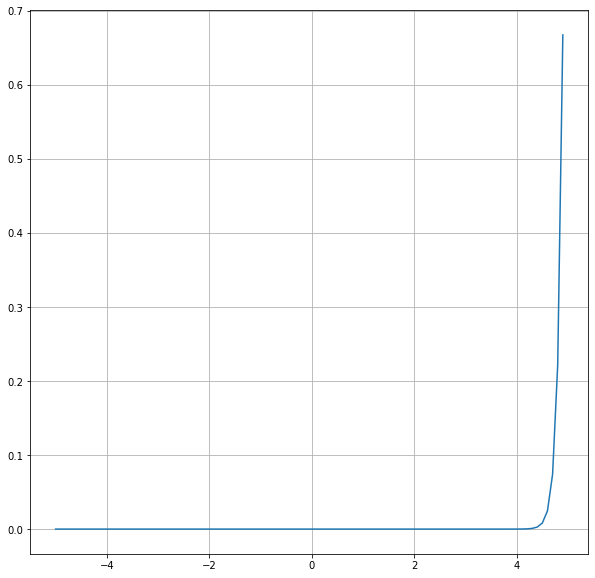

In [4]:
#
# Example of a plot of the activation function
#
t     = np.arange(-5,5,0.1)
alpha = np.arange(-50,50,1)
plt.figure(figsize=(10,10))
plt.plot(t,softmax(t,alpha))
plt.grid(True)
plt.show()

## Definition of a simple neural network

We use a one-layer fully-connected neural network with the <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax</a> activation function.


In [5]:
def NN(x,W):
    """
    # One-layer fully connected neural network
    # x: image, i.e. 784x1 vector (28x28)
    # W: weight matrices of shape 10x784   
    """
    l = np.size(W[:,0])
    pred = softmax(W@x, np.zeros((l,1)))
    
    return pred

## Definition of the loss function

The loss function is the <a href="https://en.wikipedia.org/wiki/Cross_entropy">cross-entropy</a> defined by 

$$J(W)=-\sum_{i=1}^N p_i \log(q_i(W)),$$ where $N$ is the number of classes, $(p_i)_{i=1:N}$ are the probabilities of  a data from the training set to belong to a class (0 or 1 because the labels are known), and $(q_i(W))_{i=1:N}$ are the predicted probabilities from the model

$$\forall i=1:N, \quad q_i(W)=[\sigma_{\alpha}(Wx)]_i.$$

$$\sigma_{\alpha} : \mathbb{R}^p\rightarrow [0,1]^p, \quad \mbox{ s.t.} \quad[\sigma_{\alpha}(x)]_i=\frac{e^{x_i+\alpha_i}}{\displaystyle{\sum_{j=1}^{p}e^{x_j+\alpha_j}}}\quad \forall i=1:p. $$  


In [6]:
#
# Loss function = Cross-entropy
#
def cross_entropy(pred,target,x):
    """
    pred:   predicted probabilities (q(W))
    target: probabilities (p)
    x:      image 
    """ 
    #
    # return ce (cross_entropy)
    #
    ce = - np.sum(target.T@np.log(pred))
    #
    # gradient of the cross-entropy
    #
    s    = pred 
    u    =  np.ones((s.shape[0],1))
    g    = (-u.T.dot(target)*(s.dot(x.T))+target*x.T)
    grad = -g.reshape(x.shape[0]*target.shape[0],1)
    
    return ce,grad
#
# Main function 
#
def f(W,x,target):
    """
    W:      weights
    target: probabilities (p)
    x:      image
    """
    #
    # return ce, grad, pred (cross_entropy, gradient, predicted probabilities)
    #
    pred = NN(x,W)
    ce,grad = cross_entropy(pred,target,x)
    
    return ce,grad,pred

In [7]:
#
# Test information on the gradient with calls of f
#

# Define weight matrices
W      = np.random.rand(10,Xtrain.shape[1])
eps    = 1e-8
d      = np.random.rand(10,Xtrain.shape[1])
Wtilde = W+eps*d

# Retrieve the information on the gradients
res    = (f(Wtilde,Xtrain[0],targets_train[0])[0]-f(W,Xtrain[0],targets_train[0])[0])/eps
print(res)

g      = f(W,Xtrain[0],targets_train[0])[1]
print(g.T.dot(d.reshape(7840,1)))

0.10467333666497325
[[0.10467573]]


## Generating batches 

In [8]:
#
# Function to create batches of samples to be used later in the training phase
#
def create_batches(x,bs):
    """
    x : set to be considered (array)
    bs: batch size (scalar)
    """
    batches = []
    ind     = np.arange(x.shape[0])
    random.shuffle(ind)
    nbatch  = ind.shape[0]//bs
    rest    = ind.shape[0]%bs
    
    for n in range(nbatch):
        batches +=[ind[bs*n:bs*(n+1)]]
    
    # Put the remaining elements in a last batch
    if rest !=0:        
        batches += [ind[-rest:]]
        
    return batches

## Training of the neural network

In [35]:
history    = {}
eta        = 1e-5 # learning rate
momentum   = 0.   # momemtum factor
N_EPOCHS   = 10  
BatchSizes = [10000,1024,256] # try different batch sizes for the analysis

for bs in BatchSizes:
    #
    # Sensitivity to the batch size to be investigated in the analysis
    #
    print('batch size=',bs)
    
    history[bs]={'train loss':[],'train acc':[],'test loss':[0], 'test acc':[0]}
    
    # Initialization of the weights
    w = np.random.rand(10,Xtrain.shape[1])
    
    for n in range(N_EPOCHS):
        # Minimization of the loss function
        
        Batches=create_batches(Xtrain,bs)
        
        # boucle sur les batchs créer en fonction de leur taille bs
        for batch in Batches:
            # Loop on the batches
            sum_grad = 0
            ce_train = 0
            train_acc = 0
            
            for indx in batch:
                
                # pour chaque indices que l'on trouve dans le
                # lot courant (batch), on ajoute le gradient et la
                # cross-entropy calculés pour le x correspondant de Xtrain
                # et la valeur que l'on souhaite obtenir de targets_train
                # pour pouvoir ensuite les moyenner et faire évoluer le 
                # modèle w 
                
                x = Xtrain[indx]
                target = targets_train[indx]
                ce,grad,pred = f(w,x,target)
                sum_grad += grad
                ce_train += ce
                
                # la précision augmente si la prédiction du
                # modèle vaut la valeur voulue 
                
                prediction = list(pred).index(np.max(pred))
                true = list(target).index(1)
                if prediction==true:
                    train_acc += 1
                    
            history[bs]['train acc'] += [train_acc/batch.shape[0]]
            history[bs]['train loss'] += [ce_train/batch.shape[0]]
            
            # on met à jour la matrice des poids en fonction de la moyenne
            # faite sur les gradients calculés afin de faire évoluer 
            # les poids vers un modèle cohérent avec les données de formation
            # présente dans Xtrain 
            
            sum_grad = sum_grad.reshape(w.shape[0],w.shape[1])
            w = w-eta*sum_grad
            
            
        # Test accuracy at the end of each epoch  
        test_acc = 0
        ce_test = 0
        
        # on test pour les valeurs présentes dans les données de tests
        # Xtest si le modèle des poids w calculés précédemment 
        # donne une bonne approximation des valeurs voulues (targets_test)
        
        for ind_test,x in enumerate(Xtest):
            lab = targets_test[ind_test]
            ce,_,pred = f(w,x,lab)
            ce_test += ce
            
            # on teste la précsion du les données de test 
            # comme précédemment avec les données de training 
            
            prediction = list(pred).index(np.max(pred))
            true = list(lab).index(1)
            if prediction==true:
                    test_acc += 1
                    
        history[bs]['test acc'] += [test_acc/Xtest.shape[0]]
        history[bs]['test loss'] += [ce_test/Xtest.shape[0]]
        
        print('Epoch number :', n+1,'test accuracy:',history[bs]['test acc'][n+1],'test loss',history[bs]['test loss'][n+1])
        

    print('\n')

batch size= 10000
Epoch number : 1 test accuracy: 0.1485 test loss 3.143835883949557
Epoch number : 2 test accuracy: 0.2312 test loss 2.500993820516153
Epoch number : 3 test accuracy: 0.3272 test loss 2.054500493147458
Epoch number : 4 test accuracy: 0.4218 test loss 1.7408070744937174
Epoch number : 5 test accuracy: 0.4964 test loss 1.518703597998039
Epoch number : 6 test accuracy: 0.5526 test loss 1.3569838692534288
Epoch number : 7 test accuracy: 0.5945 test loss 1.2352402916933678
Epoch number : 8 test accuracy: 0.6254 test loss 1.1407295109508995
Epoch number : 9 test accuracy: 0.6532 test loss 1.0651682149347566
Epoch number : 10 test accuracy: 0.6745 test loss 1.003457839558879


batch size= 1024
Epoch number : 1 test accuracy: 0.1669 test loss 3.093261539960005
Epoch number : 2 test accuracy: 0.2503 test loss 2.5008526425383164
Epoch number : 3 test accuracy: 0.3487 test loss 2.0897625131172375
Epoch number : 4 test accuracy: 0.436 test loss 1.8002992686116042
Epoch number : 5 

## Plots of the evolution of the loss function

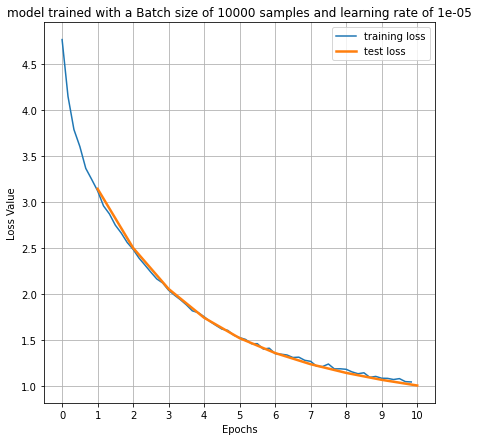

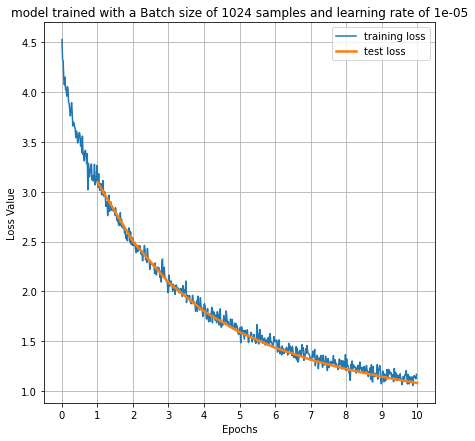

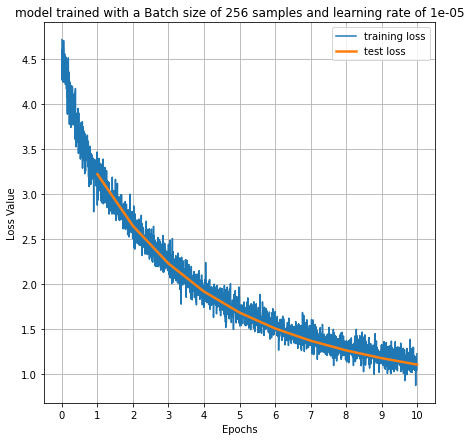

In [36]:
for bs in BatchSizes:
       
    n_batch = Xtrain.shape[0]//bs     
    if Xtrain.shape[0]%bs!=0:
        n_batch+=1
        
    E  = [n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[bs]['train loss'],label = 'training loss')
    plt.plot(E[1:],history[bs]['test loss'][1:],linewidth=2.5,label = 'test loss')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    #plt.ylim([0,np.max(history[bs]['test loss'])+2])
    plt.grid(True)
    plt.legend()
    plt.title(f'model trained with a Batch size of {bs} samples and learning rate of {eta}')
    plt.show()

## Plots of the evolution of the accuracy

batch size= 10000
nombre de batch= 6


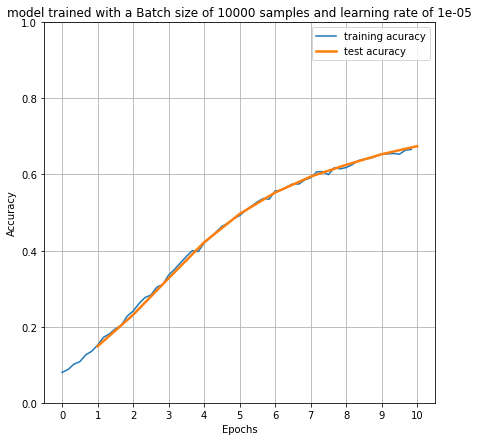

batch size= 1024
nombre de batch= 59


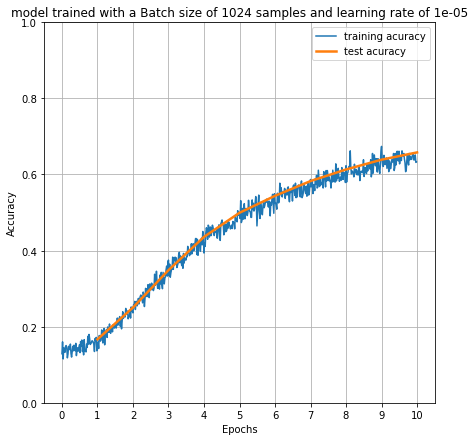

batch size= 256
nombre de batch= 235


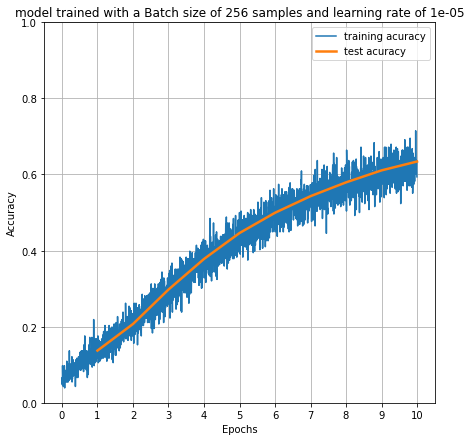

In [37]:
for bs in BatchSizes:
    print('batch size=',bs)   
    n_batch = Xtrain.shape[0]//bs     
    if Xtrain.shape[0]%bs!=0:
        n_batch+=1
        
    print('nombre de batch=',n_batch)
    E=[n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[bs]['train acc'] ,label  = 'training acuracy')
    plt.plot(E[1:],history[bs]['test acc'][1:],linewidth=2.5,label = 'test acuracy')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.title(f'model trained with a Batch size of {bs} samples and learning rate of {eta}')
    plt.ylim([0,1])
    plt.legend()
    
    plt.show()

## Analysis of the results

Please provide your comments on the sensitivity of the results to the parameters involved in the learning process (batch size, learning rate, momentum).

### Your comments:

**Influence du batch size :** (eta = 1e-5, momentum = 0.)\
Le batch size correspond à la taille des lots de 'training' ou de formation du modèle. On observe que plus cette taille est faible, plus le modèle est précis par rapport aux données réelles. Les test sur la précision et la perte sont meilleurs avec une taille de lots plus petite : la perte est plus faible, de 1.12 pour une taille de lots de 1000 et de 1.07 pour une taille de 256, et la précision est aussi élevée, de 0.63 pour un taille de 1000 et de 0.66 pour une taille de 256. En effet lorsque l'on augmente le batch size, on prend en compte plus de valeur pour le calcul de la formation du modèle dans chacun des lots, ce qui est plus rapide pour les calculs du modèle mais donne une précision plus faible sur le résultat final. \
Les graphiques de l'évolution de la précsion ou de la perte montrent cependant que avec une taille de lots plus petite, la convergence lors de la formation du modèle est plus faible. Les valeurs de training oscillent autour de la valeur de test lorsque l'on trace leurs courbes en fonction de l'epoch, et cette oscillation est d'autant plus importante que la taille des lots est faible. 

**Influence du learning rate :** (batch size = [1000, 1024, 256] momentum = 0.) \
Le taux d'apprentissage permet de modifier les valeurs des poids du modèle. Si celui-ci est faible, le modèle évolue très peu et on obtient des valeurs de perte et de précision mauvaises. \
On obtient pour une valeur de eta = 1e-10, pour epoch = 10 :\
batch size = 1000 : test accuracy: 0.1102 test loss 4.820192163127327 \
batch size = 256 : test accuracy: 0.1194 test loss 4.1981964168718235\
Graphiquemenent, les valeurs de training varient avec une grande amplitude autour de la valeur de test, mais il y a très peu d'augmentation de la précsion et de dimunition de la perte sur les valeurs de test. \
Pour un taux plus élevé on obtient pour eta = 1e-5, epoch = 10 : batch size = 256 : test accuracy: 0.66 test loss 1.07\
Graphiment on observe une augmentation de la précision et une diminution de la perte pour toutes les tailles de batch qui a la forme d'une courbe évoluant progressivement en fonction de epoch. \
Pour un taux plus élevé on obtient pour une valeur de eta = 1e-3, pour epoch = 10 : batch size = 256 : test accuracy: 0.915 test loss 0.3007876108761942\
La précision est très élevée comparé aux autres valeurs de eta, et la perte est aussi beaucoup plus faible.  Graphiquement on observe une croissance très importante au début de la courbe, pour des tailles de batchs faibles la courbe se stabilise après quelques epochs autour d'une valeur, alors que pour une taille élevée de batch (1000) les courbes de tests sont moins stables, et les valeurs de la précisions et de la perte n'évoluent pas de manière continue vers une valeur presque constante comme pour les autres tailles de lots. 
